In [1]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir

  Using cached setuptools-62.1.0-py3-none-any.whl (1.1 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.5.0
    Uninstalling setuptools-59.5.0:
      Successfully uninstalled setuptools-59.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 1.5.10 requires setuptools==59.5.0, but you have setuptools 62.1.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.4/952.4 KB 58.5 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 62.1.0
    Uninstalling setuptools-62.1.0:
      Successfully uninstalled setuptools-62.1.0


In [2]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "ahmedkmetwally"
kaggle_key = "2b9553005fa3e8b342be3671bdfa61ed"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

In [4]:
!pip install kaggle

In [8]:
!kaggle competitions download --force -c bike-sharing-demand

  0%|                                                | 0.00/189k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 189k/189k [00:00<00:00, 4.02MB/s]


In [5]:
import pandas as pd
from autogluon.tabular import TabularPredictor

/usr/local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('train.csv')
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [7]:
test = pd.read_csv('test.csv')
submission = pd.read_csv('sampleSubmission.csv')
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


Train a model using AutoGluon’s Tabular Prediction

Requirements:

    • We are prediting count, so it is the label we are setting.
    • Ignore casual and registered columns as they are also not present in the test dataset.
    • Use the root_mean_squared_error as the metric to use for evaluation.
    • Set a time limit of 10 minutes (600 seconds).
    • Use the preset best_quality to focus on creating the best model.



In [17]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [8]:
train=train.drop(['casual', 'registered'], axis=1)

In [9]:
predictor = TabularPredictor(label="count").fit(train, time_limit=600, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20220413_204840/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220413_204840/"
AutoGluon Version:  0.4.0
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    3044.11 MB
	Train Data (Original)  Memory Usage: 1.5

In [10]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.794363      11.010399  505.285541                0.000819           0.354419            3       True         15
1   RandomForestMSE_BAG_L2  -53.402585      10.218620  409.430624                0.531744          25.576200            2       True         12
2     ExtraTreesMSE_BAG_L2  -53.676894      10.213923  391.442988                0.527047           7.588563            2       True         14
3          LightGBM_BAG_L2  -55.135304       9.873887  405.978068                0.187011          22.123643            2       True         11
4          CatBoost_BAG_L2  -55.390931       9.763777  449.642716                0.076901          65.788291            2       True         13
5        LightGBMXT_BAG_L2  -60.363198      13.682828  438.328492         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -

In [32]:
predictions_1 = predictor.predict(train.loc[:,train.columns!='count'])
predictions.head()

0    13.217382
1    50.423214
2    28.474602
3     8.469372
4     3.432986
Name: count, dtype: float32

In [33]:
predictions_1.describe()

count    10886.000000
mean       191.511581
std        212.850296
min         -3.471992
25%         16.095649
50%        114.693523
75%        288.653091
max        831.103760
Name: count, dtype: float64

In [42]:
predictions_1.values.flatten()

array([ 13.217382,  50.423214,  28.474602, ..., 134.05518 ,  41.256542,
         8.932793], dtype=float32)

In [39]:
num_1 = sum(value<0 for value in predictions_1.values.flatten())
num_1

8

In [43]:
predictions_1<0

0        False
1        False
2        False
3        False
4        False
         ...  
10881    False
10882    False
10883    False
10884    False
10885    False
Name: count, Length: 10886, dtype: bool

In [45]:
predictions_1[predictions_1<0] = 0

In [46]:
sum(value<0 for value in predictions_1.values.flatten())

0

In [47]:
perf_1 = predictor.evaluate_predictions(y_true=train['count'], y_pred=predictions_1, auxiliary_metrics=True)

Evaluation: root_mean_squared_error on test data: -73.07594182879663
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -73.07594182879663,
    "mean_squared_error": -5340.093274165668,
    "mean_absolute_error": -49.799354534803584,
    "r2": 0.8372433822476963,
    "pearsonr": 0.9437791496668371,
    "median_absolute_error": -29.292088508605957
}


In [107]:
eval_metric_1 = perf_1['root_mean_squared_error']

In [49]:
submission['count']=predictions_1

In [50]:
submission.to_csv("submission.csv", index=False)

In [51]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 380kB/s]
Successfully submitted to Bike Sharing Demand

In [52]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2022-04-14 00:53:38  first raw submission               complete  2.14098      2.14098       
submission_new_hpo.csv       2022-04-13 16:06:00  new features with hyperparameters  complete  0.64732      0.64732       
submission_new_features.csv  2022-04-11 20:07:04  new features                       complete  0.68704      0.68704       
submission.csv               2022-04-09 15:56:10  first raw submission               complete  1.80863      1.80863       


array([[<AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>],
       [<AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'atemp'}>],
       [<AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>,
        <AxesSubplot:title={'center':'count'}>]], dtype=object)

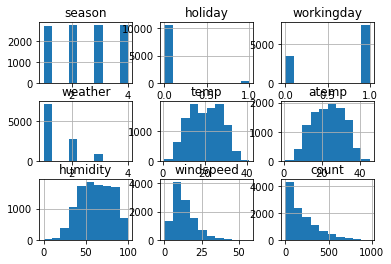

In [53]:
train.hist()

In [54]:
from datetime import datetime

In [55]:
month = [datetime.strptime(i, "%Y-%m-%d %H:%M:%S") for i in train['datetime']]

In [56]:
month

[datetime.datetime(2011, 1, 1, 0, 0),
 datetime.datetime(2011, 1, 1, 1, 0),
 datetime.datetime(2011, 1, 1, 2, 0),
 datetime.datetime(2011, 1, 1, 3, 0),
 datetime.datetime(2011, 1, 1, 4, 0),
 datetime.datetime(2011, 1, 1, 5, 0),
 datetime.datetime(2011, 1, 1, 6, 0),
 datetime.datetime(2011, 1, 1, 7, 0),
 datetime.datetime(2011, 1, 1, 8, 0),
 datetime.datetime(2011, 1, 1, 9, 0),
 datetime.datetime(2011, 1, 1, 10, 0),
 datetime.datetime(2011, 1, 1, 11, 0),
 datetime.datetime(2011, 1, 1, 12, 0),
 datetime.datetime(2011, 1, 1, 13, 0),
 datetime.datetime(2011, 1, 1, 14, 0),
 datetime.datetime(2011, 1, 1, 15, 0),
 datetime.datetime(2011, 1, 1, 16, 0),
 datetime.datetime(2011, 1, 1, 17, 0),
 datetime.datetime(2011, 1, 1, 18, 0),
 datetime.datetime(2011, 1, 1, 19, 0),
 datetime.datetime(2011, 1, 1, 20, 0),
 datetime.datetime(2011, 1, 1, 21, 0),
 datetime.datetime(2011, 1, 1, 22, 0),
 datetime.datetime(2011, 1, 1, 23, 0),
 datetime.datetime(2011, 1, 2, 0, 0),
 datetime.datetime(2011, 1, 2, 1, 0)

In [57]:
# create a new feature

dt_object_1 = [[datetime.strptime(i, "%Y-%m-%d %H:%M:%S").hour, datetime.strptime(i, "%Y-%m-%d %H:%M:%S").month]  for i in train['datetime']]
train['time'] = [i[0] for i in dt_object_1]
train['month'] = [i[1] for i in dt_object_1]

dt_object_2 = [[datetime.strptime(i, "%Y-%m-%d %H:%M:%S").hour, datetime.strptime(i, "%Y-%m-%d %H:%M:%S").month]  for i in test['datetime']]
test['time'] = [i[0] for i in dt_object_2]
test['month'] = [i[1] for i in dt_object_2]

In [58]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,time,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,3,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,4,1


In [59]:
train["season"] = train['season'].astype('category')
train["weather"] = train['weather'].astype('category')
test["season"] = test['season'].astype('category')
test["weather"] = test['weather'].astype('category')

array([[<AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'count'}>,
        <AxesSubplot:title={'center':'time'}>,
        <AxesSubplot:title={'center':'month'}>]], dtype=object)

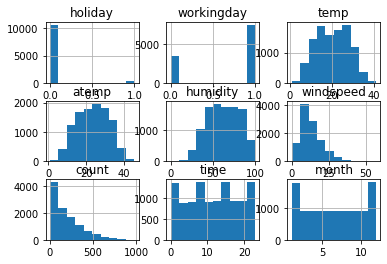

In [60]:
train.hist()

In [61]:
predictor_2 = TabularPredictor(label="count").fit(train, time_limit=600, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20220414_005556/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220414_005556/"
AutoGluon Version:  0.4.0
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2172.08 MB
	Train Data (Original)  Memory Usage: 1.

In [62]:
predictor_2.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.099244      20.275731  560.766884                0.001414           0.528799            3       True         15
1          CatBoost_BAG_L2  -30.226885      18.557794  478.680280                0.147249          79.592696            2       True         13
2          LightGBM_BAG_L2  -30.701720      18.708502  422.224854                0.297956          23.137270            2       True         11
3        LightGBMXT_BAG_L2  -31.147718      19.263641  428.034464                0.853095          28.946880            2       True         10
4     ExtraTreesMSE_BAG_L2  -31.487962      18.999518  407.271459                0.588972           8.183875            2       True         14
5   RandomForestMSE_BAG_L2  -31.572509      18.976018  428.561238         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -34.48177219869032,
  'LightGBM_BAG_L1': -3

In [63]:
predictions_2 = predictor_2.predict(train.loc[:,train.columns!='count'])
predictions_2.head()

0    26.332134
1    30.276443
2    23.019129
3     9.274798
4     4.206571
Name: count, dtype: float32

In [77]:
(predictions_2 < 0).values.any()

False

In [67]:
predictions_2.describe()

count    10886.000000
mean       192.172592
std        188.060516
min         -0.240543
25%         37.550884
50%        140.751839
75%        284.291374
max        906.848389
Name: count, dtype: float64

In [76]:
predictions_2[predictions_2<0]

Series([], Name: count, dtype: float32)

In [78]:
perf_2 = predictor_2.evaluate_predictions(y_true=train['count'], y_pred=predictions_2, auxiliary_metrics=True)

Evaluation: root_mean_squared_error on test data: -17.652631470995022
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -17.652631470995022,
    "mean_squared_error": -311.6153978507638,
    "mean_absolute_error": -10.893684647280613,
    "r2": 0.9905025126734976,
    "pearsonr": 0.9961331938653694,
    "median_absolute_error": -6.435018539428711
}


In [106]:
eval_metric_2 = perf_2['root_mean_squared_error']

In [80]:
submission_new_features=pd.read_csv('submission.csv')

In [81]:
submission_new_features["count"] = predictions_2

In [82]:
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [83]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 306kB/s]
Successfully submitted to Bike Sharing Demand

In [84]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2022-04-14 01:09:04  new features                       complete  1.97943      1.97943       
submission.csv               2022-04-14 00:53:38  first raw submission               complete  2.14098      2.14098       
submission_new_hpo.csv       2022-04-13 16:06:00  new features with hyperparameters  complete  0.64732      0.64732       
submission_new_features.csv  2022-04-11 20:07:04  new features                       complete  0.68704      0.68704       


Hyper parameter optimization

    There are many options for hyper parameter optimization.
    Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
    The hyperparameters of the models themselves that are in AutoGluon. Those need the hyperparameter and hyperparameter_tune_kwargs arguments.


In [92]:
predictor_new_hpo = TabularPredictor(label="count").fit(train, time_limit=600, presets='best_quality', hyperparameter_tune_kwargs='random')

No path specified. Models will be saved in: "AutogluonModels/ag-20220414_012437/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220414_012437/"
AutoGluon Version:  0.4.0
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2231.85 MB
	Train Data (Original)  Memory Usage: 1.

[1000]	valid_set's rmse: 36.6282
[2000]	valid_set's rmse: 34.4206


	Ran out of time, early stopping on iteration 2648. Best iteration is:
	[2648]	valid_set's rmse: 34.0367
	Stopping HPO to satisfy time limit...
Fitted model: LightGBMXT_BAG_L1/T1 ...
	-34.0367	 = Validation score   (root_mean_squared_error)
	3.77s	 = Training   runtime
	0.25s	 = Validation runtime
Hyperparameter tuning model: LightGBM_BAG_L1 ... Tuning model for up to 4.09s of the 593.19s of remaining time.


[1000]	valid_set's rmse: 33.172
[2000]	valid_set's rmse: 33.0079


	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L1/T1 ...
	-32.9564	 = Validation score   (root_mean_squared_error)
	3.55s	 = Training   runtime
	0.18s	 = Validation runtime
Hyperparameter tuning model: RandomForestMSE_BAG_L1 ... Tuning model for up to 4.09s of the 588.12s of remaining time.
	No hyperparameter search space specified for RandomForestMSE. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: RandomForestMSE_BAG_L1/T1 ...
	-38.4442	 = Validation score   (root_mean_squared_error)
	11.19s	 = Training   runtime
	0.49s	 = Validation runtime
Hyperparameter tuning model: CatBoost_BAG_L1 ... Tuning model for up to 4.09s of the 569.99s of remaining time.
	Ran out of time, early stopping on iteration 452.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	-38.4607	 = Validation score   (root_mean_squared_error)
	3.18s	 = Training   runtime
	0.01s	 = Validation runtime
Hyperparameter tuning model: ExtraTr

In [93]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                        model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         WeightedEnsemble_L3  -30.371289      19.058432  507.556625                0.000855           0.325893            3       True         22
1          CatBoost_BAG_L2/T1  -30.706913      17.321534  427.693972                0.119615          58.024008            2       True         16
2          LightGBM_BAG_L2/T1  -30.784767      17.439815  391.902092                0.237895          22.232128            2       True         14
3        LightGBMXT_BAG_L2/T1  -31.203024      18.152726  398.533881                0.950807          28.863917            2       True         13
4     ExtraTreesMSE_BAG_L2/T1  -31.509776      17.749209  377.668862                0.547289           7.998898            2       True         17
5   RandomForestMSE_BAG_L2/T1  -31.688668      17.749260

{'model_types': {'KNeighborsUnif_BAG_L1/T1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1/T1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1/T1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1/T1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1/T1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1/T1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1/T1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1/T1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2/T1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2/T1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2/T1': 'StackerEnsembleModel_XT',
  'Neural

In [94]:
predictions_3 = predictor_new_hpo.predict(train.loc[:,train.columns!='count'])
predictions_3.head()

0    26.402096
1    30.348984
2    23.842442
3     9.494377
4     4.328243
Name: count, dtype: float32

In [95]:
(predictions_3 < 0).values.any()

False

In [96]:
sum(value<0 for value in predictions<3)

0

In [97]:
predictions_3[predictions_3<0]

Series([], Name: count, dtype: float32)

In [98]:
perf_3 = predictor_new_hpo.evaluate_predictions(y_true=train['count'], y_pred=predictions_3, auxiliary_metrics=True)

Evaluation: root_mean_squared_error on test data: -16.130677263418534
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -16.130677263418534,
    "mean_squared_error": -260.1987489765677,
    "mean_absolute_error": -10.11229695594094,
    "r2": 0.992069601380994,
    "pearsonr": 0.9965924597545471,
    "median_absolute_error": -6.164896488189697
}


In [105]:
eval_metric_3 = perf_3['root_mean_squared_error']

In [100]:
submission_new_hpo = pd.read_csv('sampleSubmission.csv')

In [101]:
submission_new_hpo["count"] = predictions_3
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [102]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 315kB/s]
Successfully submitted to Bike Sharing Demand

In [103]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2022-04-14 01:37:50  new features with hyperparameters  complete  1.97042      1.97042       
submission_new_features.csv  2022-04-14 01:09:04  new features                       complete  1.97943      1.97943       
submission.csv               2022-04-14 00:53:38  first raw submission               complete  2.14098      2.14098       
submission_new_hpo.csv       2022-04-13 16:06:00  new features with hyperparameters  complete  0.64732      0.64732       


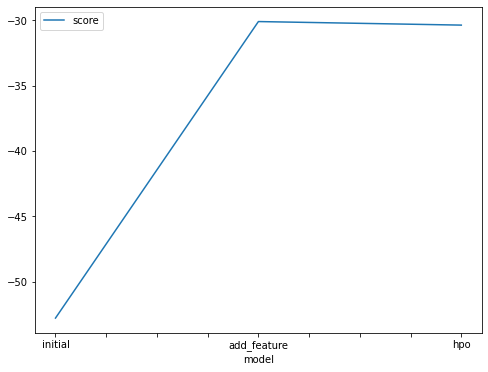

In [119]:
# The eval metric is the RMSE which is hard codedly negative to use gridsearch algorithm in the turnin of hyperparameters
fig = pd.DataFrame({
    "model":["initial", "add_feature", "hpo"],
    "score":[predictor.leaderboard(silent=True)['score_val'][0], predictor_2.leaderboard(silent=True)['score_val'][0], predictor_new_hpo.leaderboard(silent=True)['score_val'][0]],
}
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

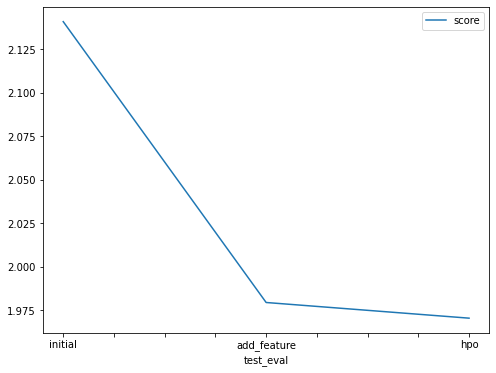

In [109]:
fig = pd.DataFrame({
    "test_eval":["initial", "add_feature", "hpo"],
    "score":[2.14098, 1.97943, 1.97042],
}
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')